## LSTM : Financial Indexes

In [1]:
from keras.layers.core import Dense, Activation, Dropout
import os
import warnings
import pandas as pd
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")

import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
%matplotlib inline


# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2

# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

# A simple little 2D matrix plotter, excluding x and y labels.
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

Using TensorFlow backend.


In [2]:

#download data from yahoo! finance
"""
data source: http://finance.yahoo.com/
"""


class YahooDailyReader():
    
    def __init__(self, symbol=None, start=None, end=None):
        import datetime, time
        self.symbol = symbol
        
        # initialize start/end dates if not provided
        if end is None:
            end = datetime.datetime.today()
        if start is None:
            start = datetime.datetime(1980,2,1)
        
        self.start = start
        self.end = end
        
        # convert dates to unix time strings
        unix_start = int(time.mktime(self.start.timetuple()))
        day_end = self.end.replace(hour=23, minute=59, second=59)
        unix_end = int(time.mktime(day_end.timetuple()))
        
        url = 'https://finance.yahoo.com/quote/{}/history?'
        url += 'period1={}&period2={}'
        url += '&filter=history'
        url += '&interval=1d'
        url += '&frequency=1d'
        self.url = url.format(self.symbol, unix_start, unix_end)
        
    def read(self):
        import requests, re, json
       
        r = requests.get(self.url)
        
        ptrn = r'root\.App\.main = (.*?);\n}\(this\)\);'
        txt = re.search(ptrn, r.text, re.DOTALL).group(1)
        jsn = json.loads(txt)
        df = pd.DataFrame(
                jsn['context']['dispatcher']['stores']
                ['HistoricalPriceStore']['prices']
                )
        df.insert(0, 'symbol', self.symbol)
        df['Date'] = pd.to_datetime(df['date'], unit='s').dt.date
        
        # drop rows that aren't prices
        df = df.dropna(subset=['close'])
        
        df = df[['Date', 'high', 'low', 'open', 'close', 
                 'volume', 'adjclose']]
        df = df.set_index('Date')
        df.index=pd.to_datetime(df.index)
        return df
    




In [3]:
# Source : https://www.kaggle.com/jdarcy/introducing-ssa-for-time-series-decomposition
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)

In [18]:
def create_dataset(dataset,columns,look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back): #range(0, 385)
        a = None
        for c in columns:
            b = dataset.loc[dataset.index[i:(i+look_back)], c].as_matrix()
            if a is None:
                a = b
            else:
                a = np.append(a,b)
        dataX.append(a)
        dataY.append(dataset.loc[dataset.index[i + look_back], columns].as_matrix())
    return np.array(dataX), np.array(dataY)

In [19]:
data = YahooDailyReader('%5EDJI').read() #dowjones30
data = data.iloc[::-1]
#df = dj

## 1.Dow Jones 30 Index

In [20]:
data = data['close']
df= data

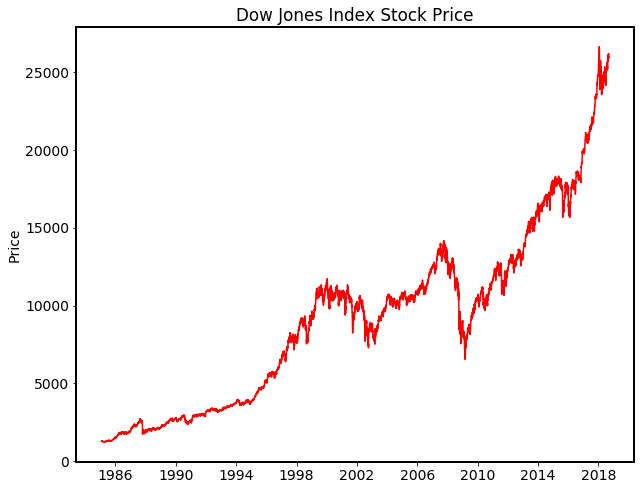

In [11]:
# The adjusted close accounts for stock splits, so that is what we should graph

plt.plot(df.index, df, 'r')
#plt.plot(tesla.index, tesla['Adj. Close'], 'r')
plt.title('Dow Jones Index Stock Price')
plt.ylabel('Price');

plt.rcParams['figure.figsize']=(20,13)

plt.show();


In [9]:
print(data.shape)
# drop rows with missing values
data.dropna(inplace=True)
print(data.shape)


(8447,)
(8447,)


In [22]:
np.random.seed(7)


### Filtering

In [10]:
# fix random seed for reproducibility
df2= data #tes
df= data.loc[data.index < pd.to_datetime('2017-06-01')] #pd.read_hdf('DeepLearning.h5', 'Data_Gold').loc[tesla.index < pd.to_datetime('2017-01-01')] 

np.random.seed(7)
# normalize the dataset
#sc = MinMaxScaler(feature_range=(0, 1))
#df.loc[:, 'Adj. Close'] = scaler.fit_transform(df.loc[:, 'Adj. Close'].reshape(-1,1))

# split into train and test sets
df = pd.DataFrame(df)

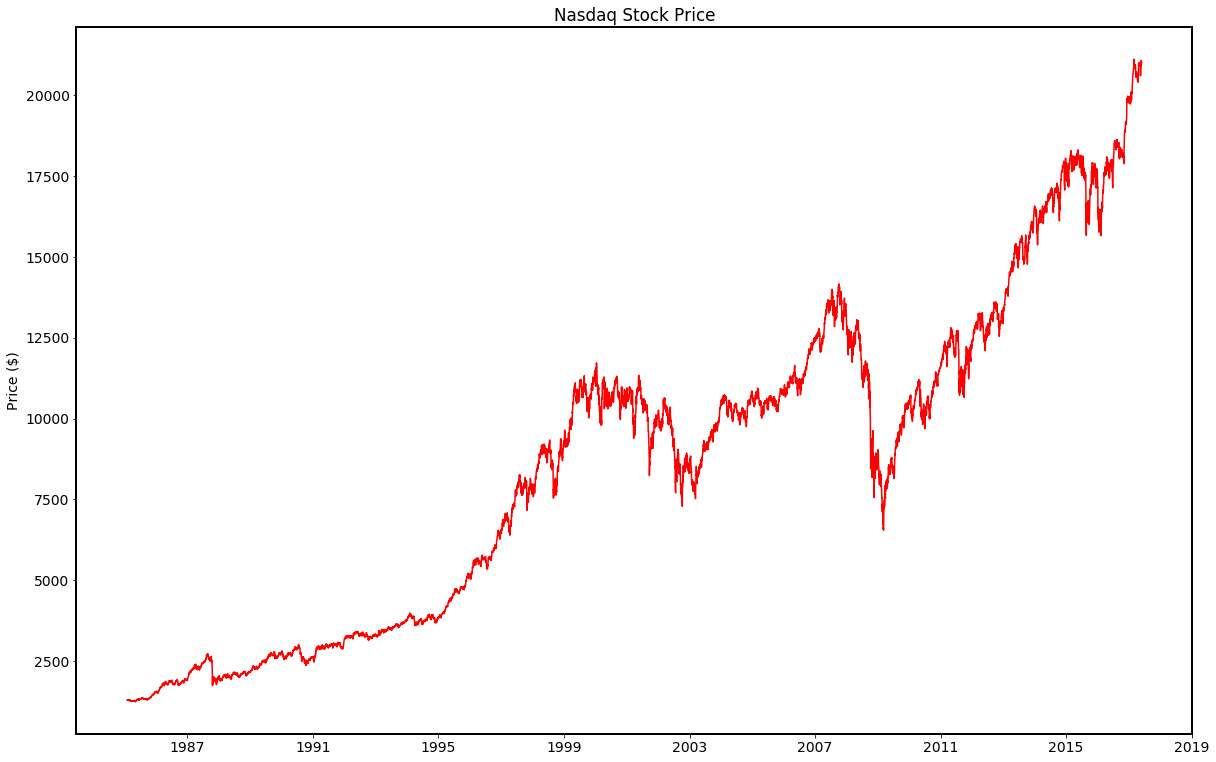

In [11]:
# The adjusted close accounts for stock splits, so that is what we should graph

plt.plot(df.index, df, 'r')
#plt.plot(tesla.index, tesla['Adj. Close'], 'r')
plt.title('Nasdaq Stock Price')
plt.ylabel('Price ($)');

plt.rcParams['figure.figsize']=(20,13)

plt.show();

In [13]:
val = df['adjclose'].values
(val.shape[0]/2)*0.7 #N/2*0.7

2853.2

In [14]:
window = 2860 # samples
accel_ssa = SSA(val, window)

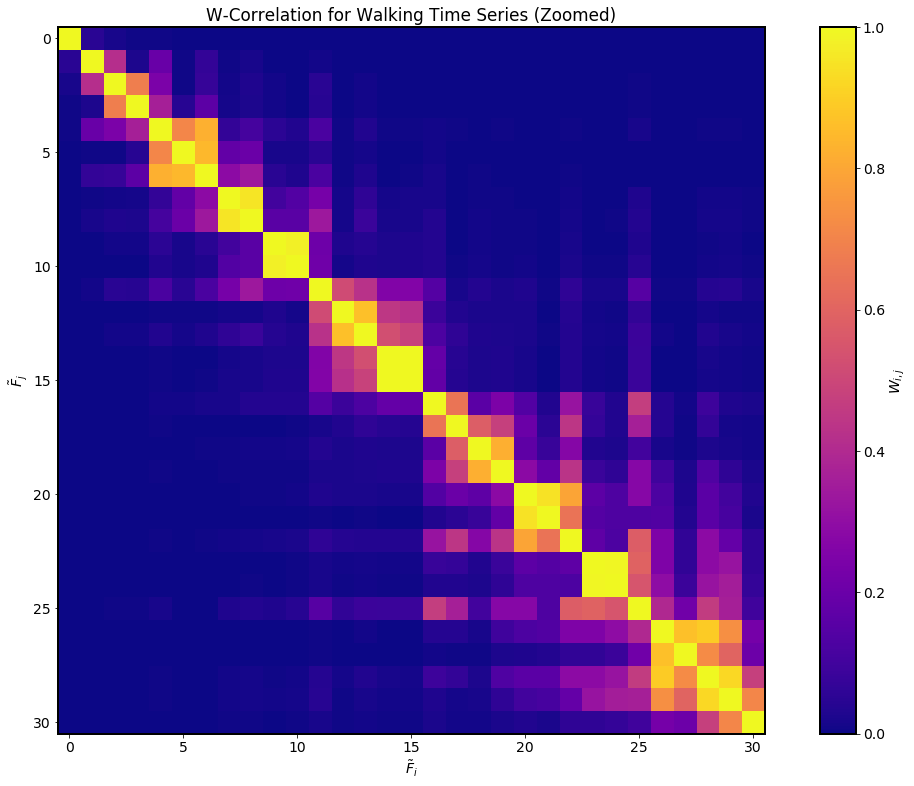

In [15]:
accel_ssa.plot_wcorr(max=30)
plt.title("W-Correlation for Walking Time Series (Zoomed)");

Signal = predictable patterns expressed in probabilities

Noise = unpredictable patterns expressed in probabilities

Forecast = the average predicted value

Error = the average difference from the average predicted value

Data smoothing in predictive analytics is, essentially, trying to find the “signal” in the “noise” by discarding data points that are considered “noisy”. The idea is to sharpen the patterns in the data and highlight trends the data is pointing to.
The implication behind data smoothing is that the data consists of two parts: one part (consisting of the core data points) that signifies overall trends or real trends, and another part that consists mostly of deviations (noise) — some fluctuating points that result from some volatility in the data. Data smoothing seeks to eliminate that second part.
Data smoothing focuses on establishing a fundamental direction for the core data points by (1) ignoring any noisy data points and (2) drawing a smoother curve through the data points that skips the wriggling ones and emphasizes primary patterns — trends — in the data, no matter how slow their emergence. Accordingly, in a numerical time series, data smoothing serves as a form of filtering.

The advantages of data smoothing are

It’s easy to implement.

It helps identify trends.

It helps expose patterns in the data.

It eliminates data points that you’ve decided are not of interest.

It helps predict the general direction of the next observed data points.

It generates nice smooth graphs.

The disadvantages of data smoothing are :

It may eliminate valid data points that result from extreme events.

It may lead to inaccurate predictions if the test data is only seasonal and not fully representative of the reality that generated the data points.

It may shift or skew the data, especially the peaks, resulting in a distorted picture of what’s going on.

It may be vulnerable to significant disruption from outliers within the data.

It may result in a major deviation from the original data.


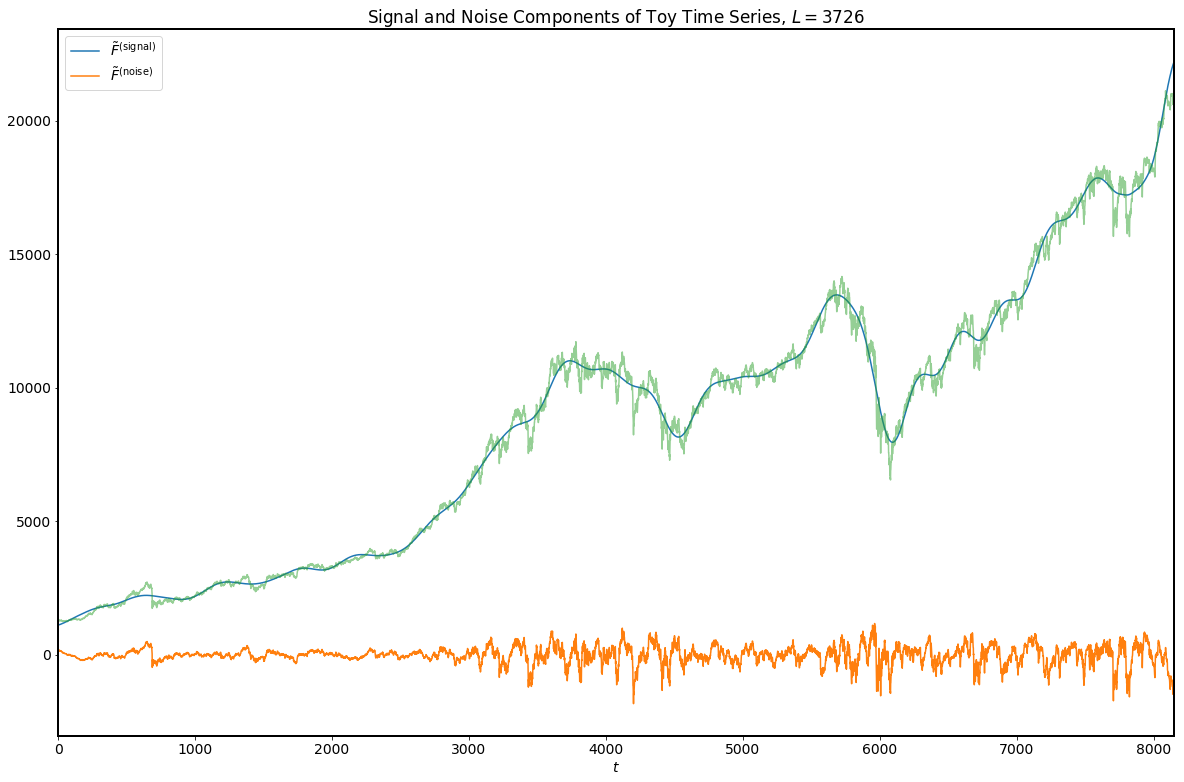

In [16]:
accel_ssa.reconstruct(slice(0,15)).plot()
accel_ssa.reconstruct(slice(15,window)).plot()
accel_ssa.orig_TS.plot( alpha=0.5)

plt.legend([r"$\tilde{F}^{\mathrm{(signal)}}$", r"$\tilde{F}^{\mathrm{(noise)}}$"])
plt.title("Signal and Noise Components of Toy Time Series, $L = 3726$")
plt.rcParams['figure.figsize']=(20,13)

plt.xlabel(r"$t$");

In [17]:
df['Smooth']= accel_ssa.reconstruct(slice(0,18)).values
df3=df

In [13]:
df

Date
1985-01-29     1292.619995
1985-01-30     1287.880005
1985-01-31     1286.770020
1985-02-01     1277.719971
1985-02-04     1290.079956
1985-02-05     1285.229980
1985-02-06     1280.589966
1985-02-07     1290.079956
1985-02-08     1289.969971
1985-02-11     1276.060059
1985-02-12     1276.609985
1985-02-13     1297.920044
1985-02-14     1287.880005
1985-02-15     1282.020020
1985-02-19     1280.589966
1985-02-20     1283.130005
1985-02-21     1279.040039
1985-02-22     1275.839966
1985-02-25     1277.500000
1985-02-26     1286.109985
1985-02-27     1281.030029
1985-02-28     1284.010010
1985-03-01     1299.359985
1985-03-04     1289.530029
1985-03-05     1291.849976
1985-03-06     1280.369995
1985-03-07     1271.530029
1985-03-08     1269.660034
1985-03-11     1268.550049
1985-03-12     1271.750000
                  ...     
2018-08-03    25462.580078
2018-08-06    25502.179688
2018-08-07    25628.910156
2018-08-08    25583.750000
2018-08-09    25509.230469
2018-08-10    25313.140

### Building the LSTM model

The model takes h timesteps from the past to predict the future, learn from it.

In [2]:
look_back = 25
a = 'close'
b= 'close'
train_size = int(len(df) * 0.7)



test_size = len(df) - train_size
train, test = df.loc[df.index[:train_size,],:], df.loc[df.index[train_size-look_back:len(df),],:] 
sc1 = MinMaxScaler(feature_range=(0, 1))
train.loc[:, a] = sc1.fit_transform(train.loc[:, a].reshape(-1,1))
sc2 = MinMaxScaler(feature_range=(0, 1))
test.loc[:, a] = sc2.fit_transform(test.loc[:, a].reshape(-1,1))
#j'ai pris -lookback comme ca on pourra predire a l'aide des donnees precedentes
#a la fin on doit avoir look_back+len(trainY)+len(testY)= len(df)= 385 ici
print(len(train), len(test))

# reshape into X=t and Y=t+1

trainX, trainY = create_dataset(train, [a],look_back)
testX, testY = create_dataset(test,[a], look_back)


trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))

#model.add(LSTM(120, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
#.add(Dropout(0.5))
        
#model.add(LSTM(120, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
#.add(Dropout(0.5))

#model.add(LSTM(4, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.add(Activation('tanh'))  #hard_sigmoid #sigmoid #linear #tanh #relu #softplus #selu #softmax

#model.compile(loss='mean_squared_error', optimizer='rmsprop')

model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(trainX, trainY, epochs=200, validation_data=(testX, testY), batch_size=100, verbose=0)
#history=model.fit(trainX, trainY, epochs=300, validation_data=(testX, testY), batch_size=7, verbose=0)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.rcParams['figure.figsize']=(20,13)
#plt.ylim((0,0.02))

plt.show()

In [1]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = sc1.inverse_transform(trainPredict)
trainY = sc1.inverse_transform(trainY)
testPredict = sc2.inverse_transform(testPredict)
testY = sc2.inverse_transform(testY)


# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))

testScore = math.sqrt(mean_squared_error(testY, testPredict))


# shift train predictions for plotting

#df['Adj. Close']=scaler.inverse_transform(df.loc[:, 'Adj. Close'].reshape(-1,1))
df['Pred'] = df.loc[df.index[0], a]

df.loc[df.index[look_back:len(trainPredict)+look_back], 'Pred'] = trainPredict.reshape(len(trainPredict))
#faut toujours reshape 
df.loc[df.index[len(trainPredict)+look_back:], 'Pred'] = testPredict.reshape(len(testPredict))

# plot baseline and predictions
plt.plot(df[a], 'r' , label = 'True')
plt.plot(df.loc[df.index[:len(trainPredict)+look_back], 'Pred'], 'g',label='Prediction Training Set')
plt.plot(df.loc[df.index[len(trainPredict)+look_back-1:], 'Pred'], 'b', label='Prediction Testing Set')
plt.legend(fontsize=18)

#la je met -1 a la place de 0 pour pouvoir recoller les graphes des prediction
plt.xlabel('Year')
plt.ylabel('Interest Rate')
plt.title('Evolution of the Interest Rate between 01-02-1985 and 01-02-2017, sample curve in red')
plt.show()

print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

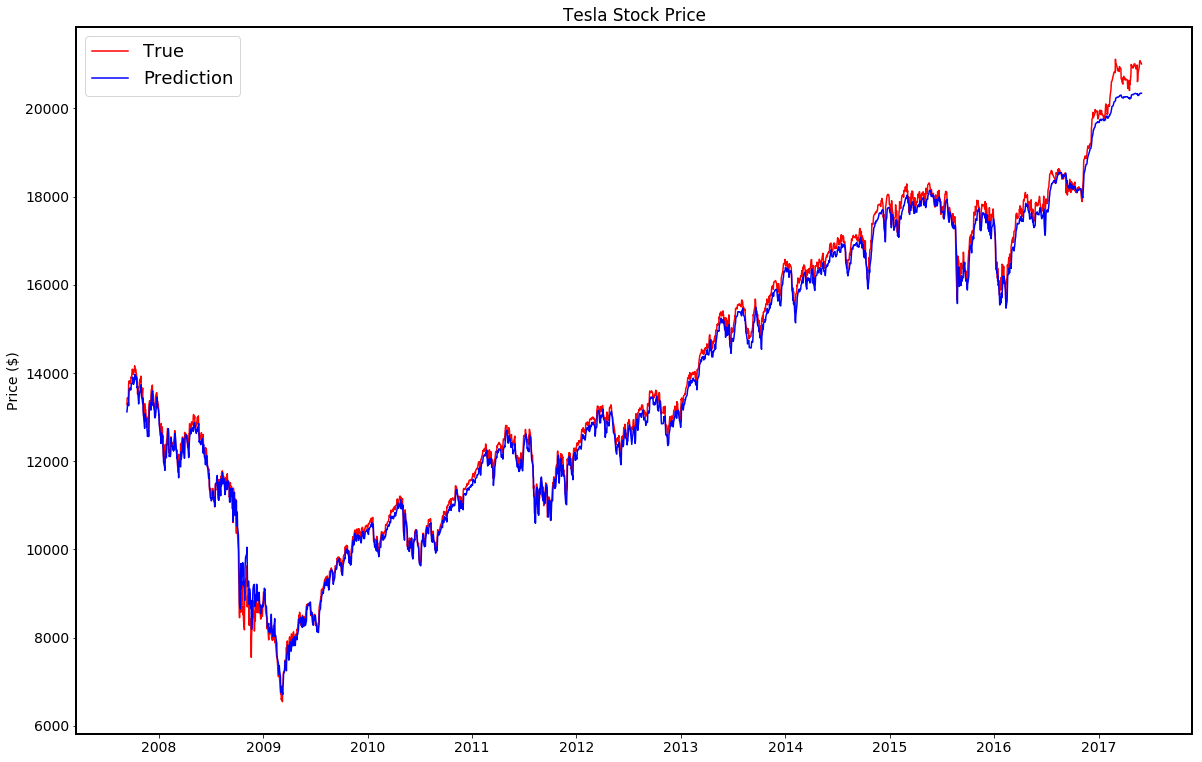

In [71]:
plt.plot(df.loc[df.index[len(trainPredict)+look_back-1:], b], 'r', label='True')
plt.plot(df.loc[df.index[len(trainPredict)+look_back-1:], 'Pred'], 'b', label='Prediction')
plt.title('Tesla Stock Price')
plt.ylabel('Price ($)');
plt.legend(fontsize=18)

plt.rcParams['figure.figsize']=(20,13)
plt.show()

### Forecast

In [72]:
def create(dataset,i, look_back=1, columns = [a]): #Adj. Close
    dataX = []
    if i == 0 :
        a = dataset.loc[:, columns].as_matrix()
    else : 
        a = dataset
    dataX.append(a)
    train2X = np.array(dataX)
    return np.reshape(train2X, (train2X.shape[0], 1, train2X.shape[1]))



In [73]:
test2 = df.loc[df.index[len(df)-look_back:],]
scaler = MinMaxScaler(feature_range=(-1, 1))
test2.loc[:, a] = scaler.fit_transform(test2.loc[:, a].reshape(-1,1)) 

list_predict = []
temp= create(test2,0, look_back)
tp = df2.shape[0]-df.shape[0]
for i in range(0,tp) :
    temp2 = model.predict(temp)
    list_predict.append(temp2[0,0])
    tp = np.append(temp,temp2)[1:look_back+1]  #temp2
    temp = create(tp,1,look_back)
testPredict2=np.array([list_predict]).reshape(-1,1)


In [ ]:
## Multivariate forecasting 